In [1]:
DATE = "2021-08-22"
TASK = "iterative-correction-via-resampling"
DIR = mkpath("$(homedir())/$(DATE)")

"/Users/cameronprybol/2021-08-22"

In [2]:
import Pkg
pkgs = [
#     "BioAlignments",
    "BioSequences",
#     "Clustering",
#     "CodecZlib",
#     "Colors",
#     "Combinatorics",
#     "DataFrames",
#     "DataStructures",
    "Dates",
#     "DelimitedFiles",
#     "Distances",
#     "EzXML",
    "FASTX",
#     "GFF3",
#     "HTTP",
#     "Impute",
#     "JSON",
    "LightGraphs",
#     "Measures",
    "MetaGraphs",
    "https://github.com/cjprybol/Mycelia.git",
#     "NumericIO",
#     "PlotlyJS",
#     "Plots",
    "Primes",
#     "Printf",
#     "ProgressMeter",
    "Random",
    "Revise",
    "SparseArrays",
#     "Statistics",
    "StatsBase",
#     "StatsPlots",
#     "StringDistances",
#     "uCSV",
#     "XLSX",
]

unregistered_packages = filter(pkg -> occursin(r"(^https|git$)", pkg), pkgs)
registered_packages = setdiff(pkgs, unregistered_packages)

for pkg in registered_packages
    try
        eval(Meta.parse("import $(pkg)"))
    catch
        Pkg.add(pkg)
        Pkg.build(pkg)
        eval(Meta.parse("import $(pkg)"))
    end
end

for pkg_url in unregistered_packages
    pkg_name = replace(basename(pkg_url), ".git" => "")
    try
        eval(Meta.parse("import $(pkg_name)"))
    catch
        Pkg.develop(url=pkg_url)
        Pkg.build(pkg_name)
        eval(Meta.parse("import $(pkg_name)"))
    end
end

┌ Info: Precompiling Mycelia [453d265d-8292-4a7b-a57c-dce3f9ae6acd]
└ @ Base loading.jl:1317
┌ Warning: Package Mycelia does not have Dates in its dependencies:
│ - If you have Mycelia checked out for development and have
│   added Dates as a dependency but haven't updated your primary
│   environment's manifest file, try `Pkg.resolve()`.
│ - Otherwise you may need to report an issue with Mycelia
└ Loading Dates into Mycelia from project dependency, future warnings for Mycelia are suppressed.


In [3]:
function assess_kmer_sparsity_in_reads(k, observations)
#     @show k, observations
    canonical_kmer_counts = Mycelia.count_canonical_kmers(BioSequences.DNAMer{k}, observations)
#     canonical_kmer_counts = Mycelia.count_canonical_kmers(BioSequences.DNAMer{k}, first(observations))
# #     @show canonical_kmer_counts
#     for i in 2:length(observations)
#         canonical_kmer_counts_ = Mycelia.count_canonical_kmers(BioSequences.DNAMer{k}, observations[i])
#         canonical_kmer_counts = merge!(+, canonical_kmer_counts, canonical_kmer_counts_)
#     end
#     canonical_kmer_counts = map(o -> Mycelia.count_canonical_kmers(BioSequences.DNAMer{k}, o), observations)...)
    total_observed_canonical_kmers = length(keys(canonical_kmer_counts))
    total_possible_canonical_kmers = (4^k)/2
    sparsity = round(total_observed_canonical_kmers/total_possible_canonical_kmers*100, digits=2)
    @show sparsity
    return sparsity
end

assess_kmer_sparsity_in_reads (generic function with 1 method)

In [4]:
function sequence_to_canonical_kmers(kmer_type, sequence)
    return (BioSequences.canonical(kmer.fw) for kmer in BioSequences.each(kmer_type, sequence))
end

sequence_to_canonical_kmers (generic function with 1 method)

In [5]:
function determine_edge_weights(graph)
    outgoing_edge_probabilities = determine_edge_weights(graph, true)
    incoming_edge_probabilities = determine_edge_weights(graph, false)
    return Dict(true => outgoing_edge_probabilities, false => incoming_edge_probabilities)
end

determine_edge_weights (generic function with 1 method)

In [6]:
function determine_edge_weights(graph, strand)
    kmers = graph.gprops[:kmers]
    outgoing_edge_weights = SparseArrays.spzeros(length(kmers), length(kmers))
    
    for (kmer_index, kmer) in enumerate(kmers)
        if !strand
            kmer = BioSequences.reverse_complement(kmer)
        end
        
        downstream_neighbors = []
        downstream_neighbor_weights = []
        for neighbor in BioSequences.neighbors(kmer)
            canonical_neighbor = BioSequences.canonical(neighbor)
            neighbor_orientation = neighbor == canonical_neighbor
            
            neighbor_index_range = searchsorted(kmers, canonical_neighbor)
            if !isempty(neighbor_index_range)
                @assert length(neighbor_index_range) == 1
                neighbor_index = first(neighbor_index_range)
                if LightGraphs.has_edge(graph, LightGraphs.Edge(kmer_index, neighbor_index))
                    edge_orientations = graph.eprops[LightGraphs.Edge(kmer_index, neighbor_index)][:orientations]
                    this_edge_orientation = (source_orientation = strand, destination_orientation = neighbor_orientation)
                    if this_edge_orientation in edge_orientations
                        edge_weight = graph.eprops[LightGraphs.Edge(kmer_index, neighbor_index)][:weight]
                        outgoing_edge_weights[kmer_index, neighbor_index] = edge_weight
                    end
                end
            end
        end
    end
    return outgoing_edge_weights
end

determine_edge_weights (generic function with 2 methods)

In [7]:
function determine_edge_probabilities(edge_weights)
    edge_probabilities = deepcopy(edge_weights)
    for orientation in [true, false]
        for row in 1:size(edge_probabilities[orientation], 1)
            edge_weights = edge_probabilities[orientation][row, :]
            edge_total = sum(edge_weights)
            for (col, edge_weight) in enumerate(edge_weights)
                if edge_total > 0
                    edge_probabilities[orientation][row, col] = edge_weight/edge_total
                else
                    edge_probabilities[orientation][row, col] = 0.0
                end
            end
        end
    end
    return edge_probabilities
end

determine_edge_probabilities (generic function with 1 method)

In [8]:
function random_step(current_vertex, current_orientation, edge_probabilities)
    outgoing_edge_likelihoods = edge_probabilities[initial_orientation][current_vertex, :]
    chosen_step = StatsBase.sample(outgoing_edge_likelihoods.nzind, StatsBase.weights(outgoing_edge_likelihoods.nzval))
    possible_orientations = observation_graph.eprops[LightGraphs.Edge(current_vertex, chosen_step)][:orientations]
    possible_orientations = filter(o -> o.source_orientation == current_orientation, possible_orientations)
    chosen_orientation = rand(possible_orientations).destination_orientation
    chosen_oriented_step = (vertex = chosen_step, orientation = chosen_orientation)
    return chosen_oriented_step
end

random_step (generic function with 1 method)

In [9]:
function random_walk(observation_graph, initial_vertex, initial_orientation, edge_probabilities; n_steps=size(edge_probabilities[true], 1))
    step_count = 0
    outgoing_edge_likelihoods = edge_probabilities[initial_orientation][initial_vertex, :]
    walk = Vector{NamedTuple{(:vertex, :orientation), Tuple{Int64, Bool}}}()
    done = (step_count > n_steps) || (sum(outgoing_edge_likelihoods) == 0)
    current_vertex = initial_vertex
    current_orientation = initial_orientation
    while !done
#         @show "choosing"
        chosen_step = StatsBase.sample(outgoing_edge_likelihoods.nzind, StatsBase.weights(outgoing_edge_likelihoods.nzval))
        chosen_step
        possible_orientations = observation_graph.eprops[LightGraphs.Edge(current_vertex, chosen_step)][:orientations]
        possible_orientations
        current_orientation
        possible_orientations = filter(o -> o.source_orientation == current_orientation, possible_orientations)
        possible_orientations
        chosen_orientation = rand(possible_orientations).destination_orientation
        chosen_oriented_step = (vertex = chosen_step, orientation = chosen_orientation)
        push!(walk, chosen_oriented_step)
        current_vertex = chosen_step
        current_orientation = chosen_orientation
        outgoing_edge_likelihoods = edge_probabilities[last(walk).orientation][last(walk).vertex, :]
        step_count += 1
#         @show outgoing_edge_likelihoods
        done = (step_count > n_steps) || (sum(outgoing_edge_likelihoods) == 0)
    end
    return walk
end

random_walk (generic function with 1 method)

In [10]:
# generate a genome
sequence_length = 10
Random.seed!(sequence_length)
sequence = BioSequences.randdnaseq(sequence_length)
sequence_id = string(hash(sequence))
record = FASTX.FASTA.Record(sequence_id, sequence)

FASTX.FASTA.Record:
   identifier: 13030913541223777560
  description: <missing>
     sequence: CAGCCGACGG

In [11]:
# randomly sample reads with errors from the genome

# 1%
error_rate = 0.01
n_reads = 100

# observations = [Mycelia.observe(FASTX.sequence(record), error_rate = error_rate) for i in 1:n_reads]
observations = [Mycelia.observe(record, error_rate = error_rate) for i in 1:n_reads];

In [12]:
# build assembly graph
k_options = Primes.primes(7, 31)
k_index = findfirst(k -> assess_kmer_sparsity_in_reads(k, observations) < 100, k_options)
k = k_options[k_index]

observations_file = "$(DIR)/LENGTH-$(sequence_length)-DEPTH-$(n_reads).fastq"
open(observations_file, "w") do io
    fastq_io = FASTX.FASTQ.Writer(io)
    for record in observations
        write(fastq_io, record)
    end
    close(fastq_io)
end

sparsity = 0.27


In [13]:
observation_graph = Mycelia.fastx_to_kmer_graph(BioSequences.DNAMer{k}, observations_file)

┌ Info: assessing kmers
└ @ Mycelia /Users/cameronprybol/.julia/dev/Mycelia/src/Mycelia.jl:1932
┌ Info: creating graph
└ @ Mycelia /Users/cameronprybol/.julia/dev/Mycelia/src/Mycelia.jl:1947


{22, 40} directed Int64 metagraph with Float64 weights defined by :weight (default weight 1.0)

In [14]:
# visualize
gfa_file = observations_file * ".k-$k.gfa"
Mycelia.graph_to_gfa(observation_graph, gfa_file)

run(`/Applications/Bandage.app/Contents/MacOS/Bandage image $(gfa_file) $(gfa_file).svg --depwidth .9 --deppower .9`)
# --nodewidth <float> Average node width (0.5 to 1000, default: 5)
# --depwidth <float>  Depth effect on width (0 to 1, default: 0.5)
# --deppower <float>  Power of depth effect on width (0 to 1, default: 0.5)

html_path_to_svg = "./" * repeat("../", length(split(pwd(), '/')) - 3)
html_path_to_svg *= replace("$(gfa_file).svg", "$(homedir())/" => "")

x = "<img src=$(html_path_to_svg)>"
display("text/html", x)
# display("image/svg+xml", read("$(gfa_file).svg", String))

# DECIDE HERE IF WE A FIRST ROUND

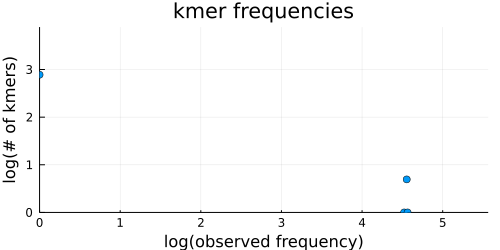

In [15]:
kmer_weights = Dict(observation_graph.vprops[v][:kmer] => observation_graph.vprops[v][:weight] for v in LightGraphs.vertices(observation_graph))
total_observed_kmers = sum(values(kmer_weights))
kmer_probabilities = Dict(k => v/total_observed_kmers for (k,v) in kmer_weights)
scale = 250
Mycelia.plot_kmer_frequency_spectra(values(kmer_weights), size=(2scale,scale), title="kmer frequencies")

In [16]:
kmers = observation_graph.gprops[:kmers]
weights = [observation_graph.vprops[v][:weight] for v in LightGraphs.vertices(observation_graph)]

edge_weights = determine_edge_weights(observation_graph)
edge_probabilities = determine_edge_probabilities(edge_weights)

Dict{Bool, SparseArrays.SparseMatrixCSC{Float64, Int64}} with 2 entries:
  0 => …
  1 => …

In [17]:
new_records = FASTX.FASTQ.Record[]
for observation in observations
    read_length = length(FASTX.sequence(observation))
    max_steps = read_length - observation_graph.gprops[:k]
    initial_vertex = StatsBase.sample(1:length(kmers), StatsBase.weights(weights))
    initial_orientation = rand(Bool)
    forward_walk = random_walk(observation_graph, initial_vertex, initial_orientation, edge_probabilities, n_steps=max_steps)
    remaining_steps = max_steps - length(forward_walk)
    reverse_walk = random_walk(observation_graph, initial_vertex, !initial_orientation, edge_probabilities, n_steps = remaining_steps)
    full_walk = [[(vertex=x.vertex, orientation=!x.orientation) for x in reverse(reverse_walk)]..., [(vertex = initial_vertex, orientation = initial_orientation)]..., forward_walk...]
    oriented_path = [(x.vertex, x.orientation) for x in full_walk]
    new_seq = Mycelia.oriented_path_to_sequence(observation_graph, oriented_path)
    new_record = FASTX.FASTQ.Record(
        FASTX.identifier(observation)*"-k$k",
        FASTX.identifier(observation),
        new_seq,
        StatsBase.sample(FASTX.quality(observation), length(new_seq))
    )
#     @show "here"
    push!(new_records, new_record)
end
new_records;

In [18]:
corrected_fastq_file = replace(observations_file, r"\.fastq" => ".k$k.fastq")
open(corrected_fastq_file, "w") do io
    fastq_writer = FASTX.FASTQ.Writer(io)
    for record in new_records
        write(fastq_writer, record)
    end
    close(fastq_writer)
end

In [19]:
observations_file = corrected_fastq_file

"/Users/cameronprybol/2021-08-22/LENGTH-10-DEPTH-100.k7.fastq"

In [20]:
observation_graph = Mycelia.fastx_to_kmer_graph(BioSequences.DNAMer{k}, observations_file)

┌ Info: assessing kmers
└ @ Mycelia /Users/cameronprybol/.julia/dev/Mycelia/src/Mycelia.jl:1932
┌ Info: creating graph
└ @ Mycelia /Users/cameronprybol/.julia/dev/Mycelia/src/Mycelia.jl:1947


{14, 24} directed Int64 metagraph with Float64 weights defined by :weight (default weight 1.0)

In [21]:
# visualize
gfa_file = observations_file * ".k-$k.gfa"
Mycelia.graph_to_gfa(observation_graph, gfa_file)

run(`/Applications/Bandage.app/Contents/MacOS/Bandage image $(gfa_file) $(gfa_file).svg --depwidth .9 --deppower .9`)
# --nodewidth <float> Average node width (0.5 to 1000, default: 5)
# --depwidth <float>  Depth effect on width (0 to 1, default: 0.5)
# --deppower <float>  Power of depth effect on width (0 to 1, default: 0.5)

html_path_to_svg = "./" * repeat("../", length(split(pwd(), '/')) - 3)
html_path_to_svg *= replace("$(gfa_file).svg", "$(homedir())/" => "")

x = "<img src=$(html_path_to_svg)>"
display("text/html", x)
# display("image/svg+xml", read("$(gfa_file).svg", String))

# DECIDE HERE IF WE ANOTHER ROUND

In [ ]:
kmer_weights = Dict(observation_graph.vprops[v][:kmer] => observation_graph.vprops[v][:weight] for v in LightGraphs.vertices(observation_graph))
total_observed_kmers = sum(values(kmer_weights))
kmer_probabilities = Dict(k => v/total_observed_kmers for (k,v) in kmer_weights)
scale = 250
Mycelia.plot_kmer_frequency_spectra(values(kmer_weights), size=(2scale,scale), title="kmer frequencies")

In [ ]:
kmers = observation_graph.gprops[:kmers]
weights = [observation_graph.vprops[v][:weight] for v in LightGraphs.vertices(observation_graph)]

edge_weights = determine_edge_weights(observation_graph)
edge_probabilities = determine_edge_probabilities(edge_weights)

In [ ]:
new_records = FASTX.FASTQ.Record[]
for observation in observations
    read_length = length(FASTX.sequence(observation))
    max_steps = read_length - observation_graph.gprops[:k]
    initial_vertex = StatsBase.sample(1:length(kmers), StatsBase.weights(weights))
    initial_orientation = rand(Bool)
    forward_walk = random_walk(observation_graph, initial_vertex, initial_orientation, edge_probabilities, n_steps=max_steps)
    remaining_steps = max_steps - length(forward_walk)
    reverse_walk = random_walk(observation_graph, initial_vertex, !initial_orientation, edge_probabilities, n_steps = remaining_steps)
    full_walk = [[(vertex=x.vertex, orientation=!x.orientation) for x in reverse(reverse_walk)]..., [(vertex = initial_vertex, orientation = initial_orientation)]..., forward_walk...]
    oriented_path = [(x.vertex, x.orientation) for x in full_walk]
    new_seq = Mycelia.oriented_path_to_sequence(observation_graph, oriented_path)
    new_record = FASTX.FASTQ.Record(
        FASTX.identifier(observation)*"-k$k",
        FASTX.identifier(observation),
        new_seq,
        StatsBase.sample(FASTX.quality(observation), length(new_seq))
    )
#     @show "here"
    push!(new_records, new_record)
end
new_records;

In [ ]:
corrected_fastq_file = replace(observations_file, r"\.fastq" => ".k$k.fastq")
open(corrected_fastq_file, "w") do io
    fastq_writer = FASTX.FASTQ.Writer(io)
    for record in new_records
        write(fastq_writer, record)
    end
    close(fastq_writer)
end

In [ ]:
observations_file = corrected_fastq_file

In [ ]:
observation_graph = Mycelia.fastx_to_kmer_graph(BioSequences.DNAMer{k}, observations_file)

In [ ]:
# visualize
gfa_file = observations_file * ".k-$k.gfa"
Mycelia.graph_to_gfa(observation_graph, gfa_file)

run(`/Applications/Bandage.app/Contents/MacOS/Bandage image $(gfa_file) $(gfa_file).svg --depwidth .9 --deppower .9`)
# --nodewidth <float> Average node width (0.5 to 1000, default: 5)
# --depwidth <float>  Depth effect on width (0 to 1, default: 0.5)
# --deppower <float>  Power of depth effect on width (0 to 1, default: 0.5)

html_path_to_svg = "./" * repeat("../", length(split(pwd(), '/')) - 3)
html_path_to_svg *= replace("$(gfa_file).svg", "$(homedir())/" => "")

x = "<img src=$(html_path_to_svg)>"
display("text/html", x)
# display("image/svg+xml", read("$(gfa_file).svg", String))

# DECIDE HERE IF WE GO ANOTHER ROUND

In [ ]:
kmer_weights = Dict(observation_graph.vprops[v][:kmer] => observation_graph.vprops[v][:weight] for v in LightGraphs.vertices(observation_graph))
total_observed_kmers = sum(values(kmer_weights))
kmer_probabilities = Dict(k => v/total_observed_kmers for (k,v) in kmer_weights)
scale = 250
Mycelia.plot_kmer_frequency_spectra(values(kmer_weights), size=(2scale,scale), title="kmer frequencies")

In [ ]:
kmers = observation_graph.gprops[:kmers]
weights = [observation_graph.vprops[v][:weight] for v in LightGraphs.vertices(observation_graph)]

edge_weights = determine_edge_weights(observation_graph)
edge_probabilities = determine_edge_probabilities(edge_weights)

In [ ]:
new_records = FASTX.FASTQ.Record[]
for observation in observations
    read_length = length(FASTX.sequence(observation))
    max_steps = read_length - observation_graph.gprops[:k]
    initial_vertex = StatsBase.sample(1:length(kmers), StatsBase.weights(weights))
    initial_orientation = rand(Bool)
    forward_walk = random_walk(observation_graph, initial_vertex, initial_orientation, edge_probabilities, n_steps=max_steps)
    remaining_steps = max_steps - length(forward_walk)
    reverse_walk = random_walk(observation_graph, initial_vertex, !initial_orientation, edge_probabilities, n_steps = remaining_steps)
    full_walk = [[(vertex=x.vertex, orientation=!x.orientation) for x in reverse(reverse_walk)]..., [(vertex = initial_vertex, orientation = initial_orientation)]..., forward_walk...]
    oriented_path = [(x.vertex, x.orientation) for x in full_walk]
    new_seq = Mycelia.oriented_path_to_sequence(observation_graph, oriented_path)
    new_record = FASTX.FASTQ.Record(
        FASTX.identifier(observation)*"-k$k",
        FASTX.identifier(observation),
        new_seq,
        StatsBase.sample(FASTX.quality(observation), length(new_seq))
    )
#     @show "here"
    push!(new_records, new_record)
end
new_records;

In [ ]:
corrected_fastq_file = replace(observations_file, r"\.fastq" => ".k$k.fastq")
open(corrected_fastq_file, "w") do io
    fastq_writer = FASTX.FASTQ.Writer(io)
    for record in new_records
        write(fastq_writer, record)
    end
    close(fastq_writer)
end

In [ ]:
observations_file = corrected_fastq_file

In [ ]:
k=7
observation_graph = Mycelia.fastx_to_kmer_graph(BioSequences.DNAMer{k}, observations_file)

In [ ]:
# visualize
gfa_file = observations_file * ".k-$k.gfa"
Mycelia.graph_to_gfa(observation_graph, gfa_file)

run(`/Applications/Bandage.app/Contents/MacOS/Bandage image $(gfa_file) $(gfa_file).svg --depwidth .9 --deppower .9`)
# --nodewidth <float> Average node width (0.5 to 1000, default: 5)
# --depwidth <float>  Depth effect on width (0 to 1, default: 0.5)
# --deppower <float>  Power of depth effect on width (0 to 1, default: 0.5)

html_path_to_svg = "./" * repeat("../", length(split(pwd(), '/')) - 3)
html_path_to_svg *= replace("$(gfa_file).svg", "$(homedir())/" => "")

x = "<img src=$(html_path_to_svg)>"
display("text/html", x)
# display("image/svg+xml", read("$(gfa_file).svg", String))

In [ ]:
# function re-sample read, anchored on a kmer chosen at random given kmer probability weights

In [ ]:
# observation_kmers = collect(sequence_to_canonical_kmers(BioSequences.DNAMer{k}, FASTX.sequence(observation)))

In [ ]:
# have it work on kmer graph rather than collapsed repeat graph

In [ ]:
# if working with collapsed repeat graph, we will have to start working with intra-node slicing of sequences
# because the unambiguous sequences are longer than the remaining length of the read overlapping that sequence

In [ ]:
# make a new graph from the re-sampled reads

In [ ]:
# compare the new graph to the error-free graph to the error-corrected graph